# 1- Setup and Load Data

## 1.1 Install libraries



In [1]:
#! pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
# Import libraries
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Avoid OOM Errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.2 Removing dodgy Images

In [5]:
# import libraries
import cv2 as cv
import imghdr

In [6]:
data_dir = 'data'

In [7]:
os.listdir(data_dir)

['happy', 'sad']

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [9]:
# number of images
happy = len(os.listdir(os.path.join(data_dir,'happy')))
sad = len(os.listdir(os.path.join(data_dir,'sad')))
print(f'We have {happy} Happy Images')
print(f'We have {sad} Sad Images')

We have 7256 Happy Images
We have 4853 Sad Images


In [10]:
# Remove all dodgy Images
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        
        try:
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            
            if tip not in image_exts:
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with Image '{image_path}'")

## 1.3 Load Data

In [11]:
# if you want know Information in details about something in tf use "??"
tf.keras.utils.image_dataset_from_directory?

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory,
labels='inferred')` will return a `tf.data.Dataset` that yields batches of
images from the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: jpeg, png, bmp, gif.
Animated gifs are truncated to the first frame.

In [12]:
# load the Data and build the data Pipeline 
data = tf.keras.utils.image_dataset_from_directory(data_dir ,batch_size=32 , image_size=(48, 48))


Found 12109 files belonging to 2 classes.


In [13]:
# Convert data and looping through it
data_iterator = data.as_numpy_iterator()

#grabbing one batch
batch = data_iterator.next()


In [14]:
# Images representation as numpy array
batch[0].shape

(32, 48, 48, 3)

In [15]:
# Labels
batch[1]

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1])

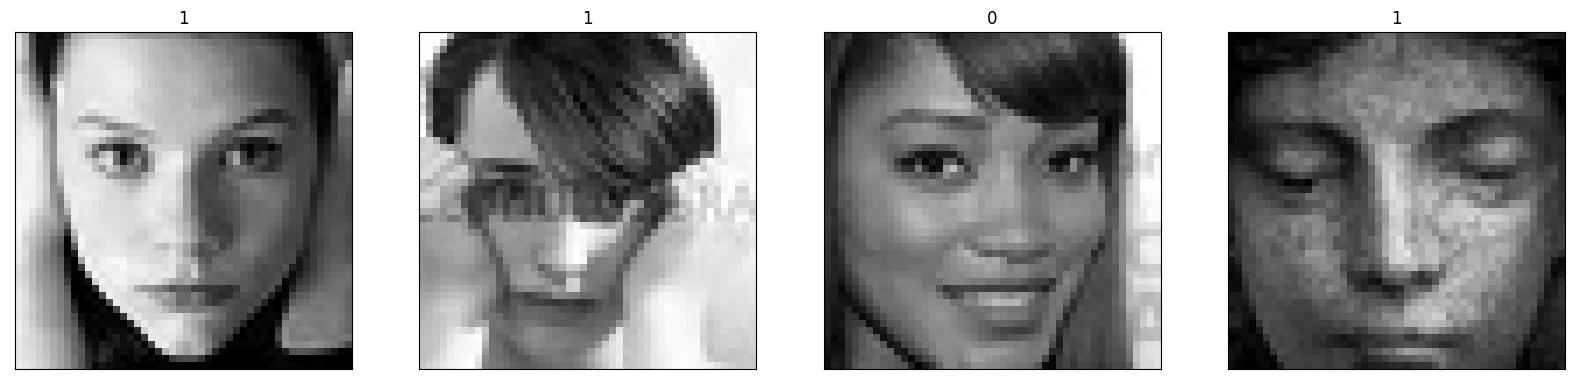

In [16]:
# Images Visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])


# 2-Preprocessing Data

## 2.1 Scale the Data

In [17]:
# check Before scaleing the data 
# max is 255.0 and min is 0.0
print(f' Max = {data.as_numpy_iterator().next()[0].max()}')
print(f' Min = {data.as_numpy_iterator().next()[0].min()}')

 Max = 255.0
 Min = 0.0


In [18]:
# apply map for scaling all images
data = data.map(lambda x,y:(x/255,y))

In [19]:
# ok Now we scaled the data 
# max is 1.0 and min is 0.0
print(f' Max become {data.as_numpy_iterator().next()[0].max()}')
print(f' Min become {data.as_numpy_iterator().next()[0].min()}')

 Max become 1.0
 Min become 0.0


## 2.2 Split Data

In [20]:
# how many Batchs in the data
print(f'Number of batches in data = {len(data)}')

Number of batches in data = 379


In [21]:
# spliting the data into train, test, validation sets
train_size, test_size, val_size = int(len(data)*.6), int(len(data)*(0.2)), int(len(data)*(.2))
print(f'train_size, test_size, val_size = {train_size, test_size, val_size}')

train_size, test_size, val_size = (227, 75, 75)


In [22]:
# apply splitting 
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size + test_size).take(val_size)

In [23]:
# check that split is Right
print(f'length of testing batches = {len(test)}')
print(f'length of training batches = {len(train)}')
print(f'length of validation batches = {len(val)}')

length of testing batches = 75
length of training batches = 227
length of validation batches = 75


# 3- The Deep Model

## 3.1 Building Deeplearning Model

In [24]:
# import dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [25]:
# initial model
Model = Sequential(name='Mido')

In [26]:
# show model API
Model?

Signature:      Model(*args, **kwargs)
Type:           Sequential
String form:    <keras.engine.sequential.Sequential object at 0x000001CF1AB72230>
File:           c:\users\dell\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\keras\engine\sequential.py
Docstring:     
`Sequential` groups a linear stack of layers into a `tf.keras.Model`.

`Sequential` provides training and inference features on this model.

Examples:

```python
# Optionally, the first layer can receive an `input_shape` argument:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
# Afterwards, we do automatic shape inference:
model.add(tf.keras.layers.Dense(4))

# This is identical to the following:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(8))

# Note that you can also omit the `input_shape` argument.
# In that case the model doesn't have any weights until the first call
# to a training/evaluation method (since it isn't yet b

In [27]:
# preforming Convoluation layers and maxplooling layers
Model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(48,48,3)))
Model.add(MaxPooling2D())

Model.add(Conv2D(32, (3,3), 1,  activation='relu'))
Model.add(MaxPooling2D())

Model.add(Conv2D(16, (3,3), 1,  activation='relu'))
Model.add(MaxPooling2D())

# preforming Flatten layers and Dense layers
Model.add(Flatten())
Model.add(Dense(256, activation='relu'))
Model.add(Dense(1, activation='sigmoid'))


In [28]:
# print model summary
Model.summary()

Model: "Mido"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0      

In [29]:
# Compile the model
Model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy',
    metrics = ['accuracy'])

## 3.2 Train

In [30]:
log_dir = 'logs'

In [31]:
# Enable Visualizations for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)


In [32]:
# Fitting the Model and Save details in History
history = Model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
227/227 [==============================] - 7s 24ms/step - loss: 0.6597 - accuracy: 0.6112 - val_loss: 0.5991 - val_accuracy: 0.6846
Epoch 2/10
227/227 [==============================] - 6s 26ms/step - loss: 0.5493 - accuracy: 0.7172 - val_loss: 0.5248 - val_accuracy: 0.7350
Epoch 3/10
227/227 [==============================] - 7s 29ms/step - loss: 0.4790 - accuracy: 0.7617 - val_loss: 0.4746 - val_accuracy: 0.7600
Epoch 4/10
227/227 [==============================] - 7s 29ms/step - loss: 0.4310 - accuracy: 0.7919 - val_loss: 0.4670 - val_accuracy: 0.7671
Epoch 5/10
227/227 [==============================] - 6s 27ms/step - loss: 0.3923 - accuracy: 0.8153 - val_loss: 0.4237 - val_accuracy: 0.7987
Epoch 6/10
227/227 [==============================] - 6s 28ms/step - loss: 0.3664 - accuracy: 0.8264 - val_loss: 0.4089 - val_accuracy: 0.8042
Epoch 7/10
227/227 [==============================] - 6s 27ms/step - loss: 0.3371 - accuracy: 0.8460 - val_loss: 0.3922 - val_accuracy: 0.8150

## 3.3 Plot Performance

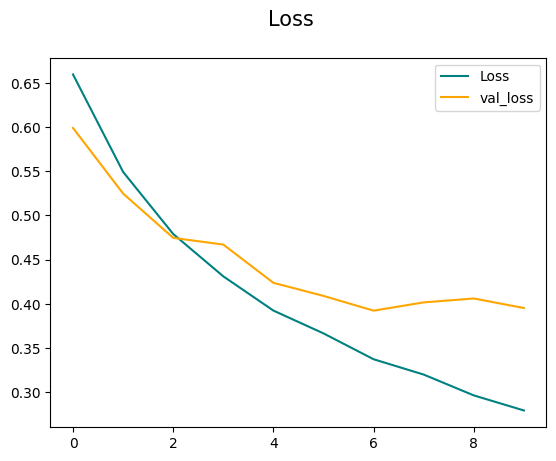

In [33]:
# plot loss vs val_loss to see model performance
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='Loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.suptitle("Loss", fontsize=15)
plt.legend()
plt.show()

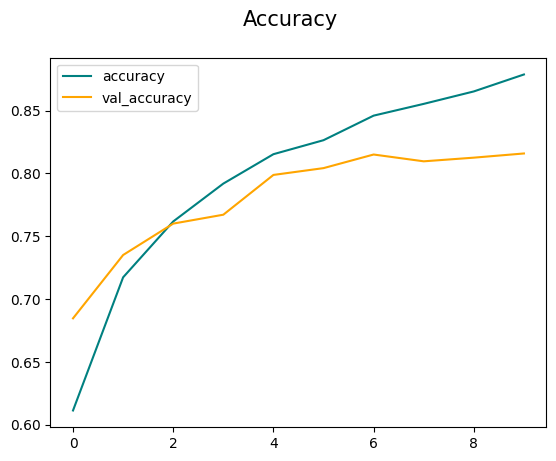

In [34]:
# plot accuracy vs val_accuracy to see model performance
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.suptitle("Accuracy", fontsize=15)
plt.legend()
plt.show()

# 4- Evaluation Performance

## 4.1 Evaluate

In [35]:
# import metrics
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
# make instance 
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
# compute metrics on test data
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = Model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 23ms/step


In [38]:
# Show metrics result
print(f'Accuracy = {acc.result().numpy()}')
print(f'Recall = {re.result().numpy()}')
print(f'Precision = {pre.result().numpy()}')

Accuracy = 0.831250011920929
Recall = 0.7949259877204895
Precision = 0.7808930277824402


## 4.2 Test

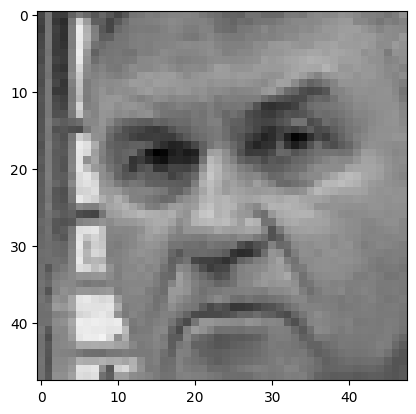

In [39]:
# resize the image
test_img = cv.imread('Test_images\Sad.jpg')
#plt.imshow(test_img)
#resize = tf.image.resize(test_img , (256,256))
plt.imshow(test_img.astype(int))
plt.show()

In [40]:
# expand because the model expected a batch of images
yhat = Model.predict(np.expand_dims(test_img/255.0, 0))

1/1 [==============================] - 0s 171ms/step


In [41]:
# Happy or Sad
if yhat > 0.5 :
    print(f'Predicted Class is Sad')
else:
    print(f'Predicted Class is Happy')

Predicted Class is Sad


# 5- Save the Model

In [42]:
# Save first version of our model
Model.save(os.path.join('models','happy_sad_model_V1.h5'))

In [43]:
# How to load the new model
from tensorflow.keras.models import load_model
new_model = load_model(os.path.join('models','happy_sad_model_V1.h5'))

 **Done Here , Alhamdulla :)** 